In [141]:
import timeit
import logging
from tqdm import tqdm
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt
from random import randint
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import yfinance
from abc import ABC, abstractmethod

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

In [304]:
class TimeSeriesModel:
    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)

    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def fit(self, data, sigma_sd=0.5, mcmc_samples=0, chains=4, cores=4):
        self.mcmc_samples = mcmc_samples

        self.data = data.reset_index(drop=True)
        self._process_data()

        self.model = pm.Model()
        self.model_idxs = {}
        mu = self.definition(self.model, self.data, self.model_idxs)

        with self.model:
            sigma = pm.HalfNormal("sigma", sigma_sd, initval=1.0)
            obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=self.data["y"])

            self.map_approx = None
            self.trace = None
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=False, maxeval=1e4)
            else:
                self.trace = pm.sample(self.mcmc_samples, chains=chains, cores=cores)

    def _make_future_df(self, days):
        future = pd.DataFrame(
            {
                "ds": pd.DatetimeIndex(
                    pd.concat(
                        (
                            self.data["ds"],
                            pd.date_range(
                                self.ds_max,
                                self.ds_max + pd.Timedelta(days, "D"),
                                inclusive="right",
                            ).to_series(),
                        )
                    )
                )
            }
        )
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future

    def predict(self, days):
        future = self._make_future_df(days)
        forecast = self._predict(future, self.mcmc_samples, self.map_approx, self.trace)

        future["yhat"] = forecast * self.y_max
        for model_type, model_cnt in self.model_idxs.items():
            for model_idx in range(model_cnt):
                future[f"{model_type}_{model_idx}"] *= self.y_max

        return future

    def _predict(self, future, mcmc_samples, map_approx, trace):
        if mcmc_samples == 0:
            return self._predict_map(future, map_approx)

        return self._predict_mcmc(future, trace)

    def __add__(self, other):
        return AdditiveTimeSeries(self, other)

    def __mul__(self, other):
        return MultiplicativeTimeSeries(self, other)


class AdditiveTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) + self.right.definition(
            *args, **kwargs
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) + self.right._predict(
            *args, **kwargs
        )


class MultiplicativeTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) * (
            1 + self.right.definition(*args, **kwargs)
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) * (
            1 + self.right._predict(*args, **kwargs)
        )


class LinearTrend(TimeSeriesModel):
    def __init__(
        self,
        n_changepoints=25,
        changepoint_range=0.8,
        slope_mean=0,
        slope_sd=5,
        intercept_mean=0,
        intercept_sd=5,
        delta_mean=0,
        delta_sd=0.05,
    ):
        self.n_changepoints = n_changepoints
        self.changepoint_range = changepoint_range
        self.slope_mean = slope_mean
        self.slope_sd = slope_sd
        self.intercept_mean = intercept_mean
        self.intercept_sd = intercept_sd
        self.delta_mean = delta_mean
        self.delta_sd = delta_sd

    def definition(self, model, data, model_idxs):
        model_idxs["lt"] = model_idxs.get("lt", 0)
        self.model_idx = model_idxs["lt"]
        model_idxs["lt"] += 1

        t = np.array(data["t"])
        hist_size = int(np.floor(data.shape[0] * self.changepoint_range))
        cp_indexes = (
            np.linspace(0, hist_size - 1, self.n_changepoints + 1).round().astype(int)
        )
        self.s = np.array(data.iloc[cp_indexes]["t"].tail(-1))

        # * 1 casts the boolean to integers
        A = (t[:, None] > self.s) * 1

        with model:
            slope = pm.Normal(
                f"lt_{self.model_idx} - slope", self.slope_mean, self.slope_sd
            )
            intercept = pm.Normal(
                f"lt_{self.model_idx} - intercept",
                self.intercept_mean,
                self.intercept_sd,
            )

            delta_sd = self.delta_sd
            if self.delta_sd is None:
                delta_sd = pm.Exponential(f"lt_{self.model_idx} - tau", 1.5)

            delta = pm.Laplace(
                f"lt_{self.model_idx} - delta",
                self.delta_mean,
                delta_sd,
                shape=self.n_changepoints,
            )

            trend = pm.Deterministic(
                f"lt_{self.model_idx} - trend",
                (slope + pyt.tensor.dot(A, delta)) * t
                + (intercept + pyt.tensor.dot(A, -self.s * delta)),
            )

        return trend

    def _predict_map(self, future, map_approx):
        new_A = (np.array(future["t"])[:, None] > self.s) * 1

        forecast = np.array(
            (
                map_approx[f"lt_{self.model_idx} - slope"]
                + np.dot(new_A, map_approx[f"lt_{self.model_idx} - delta"])
            )
            * future["t"]
            + (
                map_approx[f"lt_{self.model_idx} - intercept"]
                + np.dot(
                    new_A,
                    (-self.s * map_approx[f"lt_{self.model_idx} - delta"]),
                )
            )
        )
        future[f"lt_{self.model_idx}"] = forecast

        return forecast

    def _predict_mcmc(self, future, trace):
        new_A = (np.array(future["t"])[:, None] > self.s) * 1

        delta = trace["posterior"][f"lt_{self.model_idx} - delta"].to_numpy().mean(0)
        slope = trace["posterior"][f"lt_{self.model_idx} - slope"].to_numpy().mean(0)
        intercept = (
            trace["posterior"][f"lt_{self.model_idx} - intercept"].to_numpy().mean(0)
        )

        forecast = (
            (slope + np.dot(new_A, delta.T)).T * future["t"].to_numpy()
            + (intercept + np.dot(new_A, (-s * delta).T)).T
        ).mean(0)
        future[f"lt_{self.model_idx}"] = forecast

        return forecast


class FourierSeasonality(TimeSeriesModel):
    def __init__(self, period, series_order, beta_mean=0, beta_sd=10):
        self.period = period
        self.series_order = series_order
        self.beta_mean = beta_mean
        self.beta_sd = beta_sd

    def _fourier_series(self, data):
        # convert to days since epoch
        NANOSECONDS_TO_SECONDS = 1000 * 1000 * 1000
        t = (
            data["ds"].to_numpy(dtype=np.int64)
            // NANOSECONDS_TO_SECONDS
            / (3600 * 24.0)
        )

        x_T = t * np.pi * 2
        fourier_components = np.empty((data["ds"].shape[0], 2 * self.series_order))
        for i in range(self.series_order):
            c = x_T * (i + 1) / self.period
            fourier_components[:, 2 * i] = np.sin(c)
            fourier_components[:, (2 * i) + 1] = np.cos(c)

        return fourier_components

    def definition(self, model, data, model_idxs):
        model_idxs["fs"] = model_idxs.get("fs", 0)
        self.model_idx = model_idxs["fs"]
        model_idxs["fs"] += 1

        x = self._fourier_series(data)

        with model:
            beta = pm.Normal(
                f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                mu=self.beta_mean,
                sigma=self.beta_sd,
                shape=2 * self.series_order,
            )

        return pyt.tensor.dot(x, beta)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _predict_map(self, future, map_approx):
        forecast = self._det_seasonality_posterior(
            map_approx[
                f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
            ],
            self._fourier_series(future),
        )
        future[f"fs_{self.model_idx}"] = forecast

        return forecast

    def _predict_mcmc(self, days, trace):
        forecast = self._det_seasonality_posterior(
            trace["posterior"][
                f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
            ]
            .to_numpy()
            .mean(0),
            self._fourier_series(future),
        ).T.mean(0)
        future[f"fs_{self.model_idx}"] = forecast

        return forecast

In [305]:
new_model = (LinearTrend(n_changepoints=1) + FourierSeasonality(7, 2)) * (LinearTrend(n_changepoints=5) * FourierSeasonality(365.25, 10))
new_model.fit(df[start:start + window])
preds = new_model.predict(30)
preds

,ds,t,lt_0,fs_0,lt_1,fs_1,yhat
0,2005-04-18,0.000000,8984.310962,-2.634843,-1277.530177,5.624419,1148.060927
1,2005-04-19,0.001372,8986.826975,-5.166760,-1277.658254,5.244773,1149.288669
2,2005-04-20,0.002743,8989.342987,-1.635559,-1277.786331,4.847692,1151.386089
3,2005-04-21,0.004115,8991.859000,4.314374,-1277.914408,4.435912,1153.874094
4,2005-04-22,0.005487,8994.375013,4.314733,-1278.042484,4.012572,1155.662629
...,...,...,...,...,...,...,...
755,2007-05-13,1.035665,10883.900658,-0.272785,-1267.567143,-2.069339,1514.296467
756,2007-05-14,1.037037,10886.416670,-2.634843,-1267.586100,-2.148332,1514.681835
757,2007-05-15,1.038409,10888.932683,-5.166760,-1267.605058,-2.218882,1514.989705
758,2007-05-16,1.039781,10891.448696,-1.635559,-1267.624015,-2.284468,1516.110041


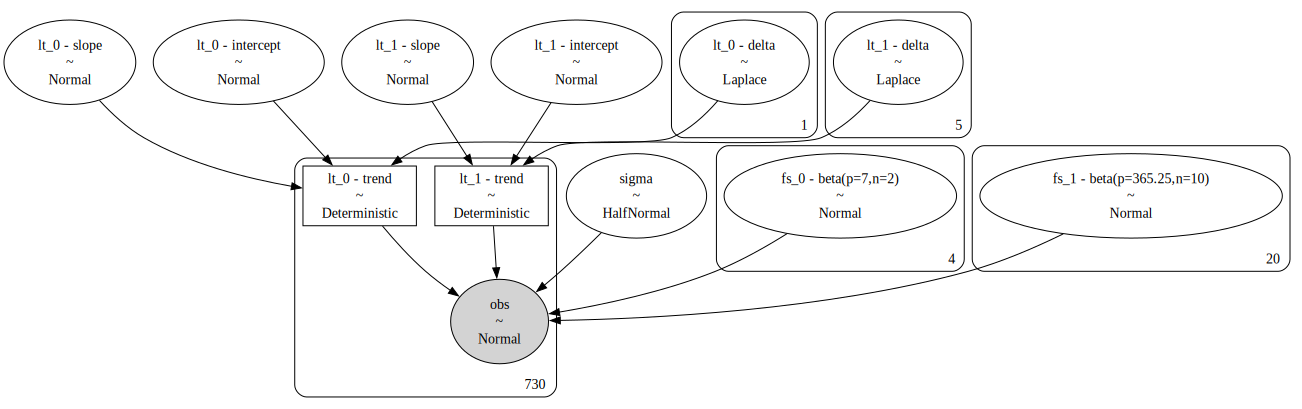

In [306]:
pm.model_to_graphviz(new_model.model)

,ds,t,lt_0,fs_0,lt_1,fs_1,yhat
730,2007-04-18,1.001372,10821.000336,-1.635559,-1267.093207,5.806976,1458.893513
731,2007-04-19,1.002743,10823.516349,4.314374,-1267.112164,5.436929,1462.243277
732,2007-04-20,1.004115,10826.032362,4.314733,-1267.131121,5.048252,1464.910145
733,2007-04-21,1.005487,10828.548375,1.080841,-1267.150079,4.643452,1467.242346
734,2007-04-22,1.006859,10831.064388,-0.272785,-1267.169036,4.225477,1469.913111
735,2007-04-23,1.008230,10833.580401,-2.634843,-1267.187994,3.797643,1472.509983
736,2007-04-24,1.009602,10836.096414,-5.166760,-1267.206951,3.363559,1475.123558
737,2007-04-25,1.010974,10838.612426,-1.635559,-1267.225909,2.927034,1478.579944
738,2007-04-26,1.012346,10841.128439,4.314374,-1267.244866,2.491987,1482.360552
739,2007-04-27,1.013717,10843.644452,4.314733,-1267.263824,2.062348,1485.296319


In [303]:
mean_absolute_percentage_error(df[start + window:start + window + 30]["y"], new_model.predict(30)[-30:]["yhat"])

0.004931503229921309

In [50]:
NANOSECONDS_TO_SECONDS = 1000 * 1000 * 1000

class MyProphet():
    def __init__(self,
                 n_changepoints=25,
                 changepoints_prior_scale=0.05,
                 changepoint_range=0.8,
                 yearly_prior_scale=10.0,
                 weekly_prior_scale=10.0,
                 mcmc_samples=0,
                 k_mean=0,
                 k_sd=5,
                 m_mean=0,
                 m_sd=5,
                 sigma=0.5,
                 delta_mean=0,
                 beta_yearly_mean=0,
                 beta_weekly_mean=0,
                 old_trace=None,
                ):
        self.n_changepoints = n_changepoints
        self.changepoints_prior_scale = changepoints_prior_scale
        self.changepoint_range = changepoint_range
        self.yearly_prior_scale = yearly_prior_scale
        self.weekly_prior_scale = weekly_prior_scale
        self.mcmc_samples = mcmc_samples
        
        self.k_mean = k_mean
        self.k_sd = k_sd
        self.m_mean = m_mean
        self.m_sd = m_sd
        self.sigma = sigma
        self.delta_mean = delta_mean
        self.beta_yearly_mean = beta_yearly_mean
        self.beta_weekly_mean = beta_weekly_mean

        self.old_trace = old_trace
        
        self.model = None
        self.init_vals = None
        self.trend_params = None
        self.yearly_seasonality_params = None
        self.weekly_seasonality_params = None
        self.map_approx = None
        self.trace = None
        self.posterior = None
        
        self.data = None
        self.y_min = None
        self.y_max = None
        self.ds_min = None
        self.ds_max = None

    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        
    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def _model_init(self):
        i0, i1 = self.data["ds"].idxmin(), self.data["ds"].idxmax()
        T = self.data["t"].iloc[i1] - self.data["t"].iloc[i0]
        k = (self.data["y"].iloc[i1] - self.data["y"].iloc[i0]) / T
        m = self.data["y"].iloc[i0] - k * self.data["t"].iloc[i0]
        delta = np.zeros(self.n_changepoints)
        self.init_vals = {"k": k, "m": m, "delta": delta, "beta_yearly": 0.0, "beta_weekly": 0.0, "sigma": 1.0}

    def _add_trend(self, priors):
        t = np.array(self.data["t"])
        hist_size = int(np.floor(self.data.shape[0] * self.changepoint_range))
        cp_indexes = np.linspace(0, hist_size - 1, self.n_changepoints + 1).round().astype(int)
        s = np.array(self.data.iloc[cp_indexes]["t"].tail(-1))
    
        # * 1 casts the boolean to integers
        A = (t[:, None] > s) * 1
    
        with self.model:
            # initial growth
            if self.old_trace is None:
                k = pm.Normal("k", self.k_mean , self.k_sd, initval=self.init_vals["k"])
            else:
                k = priors["k"]

            changepoints_prior_scale = self.changepoints_prior_scale
            if self.changepoints_prior_scale is None:
                if self.old_trace is None:
                    changepoints_prior_scale = pm.Exponential("tau", 1.5)
                else:
                    changepoints_prior_scale = priors["tau"]
        
            # rate of change
            if self.old_trace is None:
                delta = pm.Laplace("delta", self.delta_mean, changepoints_prior_scale, shape=self.n_changepoints, initval=self.init_vals["delta"])
            else:
                delta = priors["delta"]
            # offset
            if self.old_trace is None:
                m = pm.Normal("m", self.m_mean, self.m_sd, initval=self.init_vals["m"])
            else:
                m = priors["m"]
            gamma = -s * delta
            trend = pm.Deterministic("trend", (k + pyt.tensor.dot(A, delta)) * t + (m + pyt.tensor.dot(A, gamma)))

        return trend, A, s

    def _fourier_series(self, data, period=365.25, series_order=10,):
        # convert to days since epoch
        t = data["ds"].to_numpy(dtype=np.int64) // NANOSECONDS_TO_SECONDS / (3600 * 24.)
    
        x_T = t * np.pi * 2
        fourier_components = np.empty((data["ds"].shape[0], 2 * series_order))
        for i in range(series_order):
            c = x_T * (i + 1) / period
            fourier_components[:, 2 * i] = np.sin(c)
            fourier_components[:, (2 * i) + 1] = np.cos(c)
            
        return fourier_components

    def _get_seasonality_n_x(self, data, period):
        if period == "yearly":
            n = 10
            p = 365.25
        else:  # weekly
            n = 3
            p = 7
            
        return n, self._fourier_series(data, p, n)

    def _add_seasonality(self, period, mean, priors):
        n, x = self._get_seasonality_n_x(self.data, period)
        scale = self.yearly_prior_scale if period == "yearly" else self.weekly_prior_scale
    
        with self.model:
            if self.old_trace is None:
                beta = pm.Normal(
                    f"beta_{period}", 
                    mu=mean, 
                    sigma=scale, 
                    shape=2 * n, 
                    initval=np.array([mean] * 2 * n) if type(mean) is int else mean
                )
            else:
                beta = priors[f"beta_{period}"]
            
        return x, beta

    def fit(self, data):
        self.data = data.reset_index(drop=True)
        self._process_data()
        self._model_init()

        self.model = pm.Model()
        with self.model:
            priors = None
            if self.old_trace is not None:
                priors = pmx.utils.prior.prior_from_idata(
                    self.old_trace, 
                    var_names=["k", "m", "delta", "beta_yearly", "beta_weekly"] + (["tau"] if self.changepoints_prior_scale is None else [])
                )
    
            trend, A, s = self._add_trend(priors)
            x_yearly, beta_yearly = self._add_seasonality("yearly", self.beta_yearly_mean, priors)
            x_weekly, beta_weekly = self._add_seasonality("weekly", self.beta_weekly_mean, priors)
            trend += pyt.tensor.dot(x_yearly, beta_yearly) + pyt.tensor.dot(x_weekly, beta_weekly)
            # sigma = pm.HalfCauchy("sigma", 0.5, initval=1)
            sigma = pm.HalfNormal("sigma", self.sigma, initval=self.init_vals["sigma"])
            obs = pm.Normal("obs", mu=trend, sigma=sigma, observed=self.data["y"])
         
            
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=False, maxeval=1e4)
                
            else:
                self.trace = pm.sample(self.mcmc_samples, chains=4, cores=4)
                # self.posterior = pm.sample_posterior_predictive(trace=self.trace)

        self.trend_params = (trend, A, s)
        self.yearly_seasonality_params = (x_yearly, beta_yearly)
        self.weekly_seasonality_params = (x_weekly, beta_weekly)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _plot_predictions(self, future, y_true=None):
        date = future["ds"].dt.to_pydatetime()
        plt.figure(figsize=(16, 3*6))
        b = 411
        plt.subplot(b)
        plt.title("Predictions")
        plt.plot(date, future["yhat"], lw=0.5)
        plt.scatter(date[:len(self.data)], self.data["y"] * self.y_max, s=0.5, color="black")

        if y_true is not None:
            plt.scatter(date[len(self.data):], y_true, s=0.5, color="green")

        plt.subplot(b + 1)
        plt.title("Trend component")
        plt.plot(date, future["trend"], lw=0.5)

        plt.subplot(b + 2)
        plt.title("Yearly component")
        plt.plot(date, future["yearly"], lw=0.5)

        plt.subplot(b + 3)
        plt.title("Weekly component")
        plt.plot(date, future["weekly"], lw=0.5)

    def _make_future_df(self, days):
        future = pd.DataFrame({
            "ds": pd.DatetimeIndex(pd.concat((
                self.data["ds"], 
                pd.date_range(self.ds_max, self.ds_max + pd.Timedelta(days, "D"), inclusive="right").to_series(),
            )))
        })
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future
    
    def _predict_map(self, days, y_true=None, plot=False):
        _, _, s = self.trend_params
        future = self._make_future_df(days)
        new_A = (np.array(future["t"])[:, None] > s) * 1
        
        _, x_yearly = self._get_seasonality_n_x(future, "yearly")
        _, x_weekly = self._get_seasonality_n_x(future, "weekly")
        
        future["yearly"] = self._det_seasonality_posterior(self.map_approx["beta_yearly"], x_yearly) * self.y_max
        future["weekly"] = self._det_seasonality_posterior(self.map_approx["beta_weekly"], x_weekly) * self.y_max        
        future["trend"] = np.array((
            (self.map_approx["k"] + np.dot(new_A, self.map_approx["delta"])) * future["t"] + 
            (self.map_approx["m"] + np.dot(new_A, (-s * self.map_approx["delta"])))
        ) * self.y_max)

        future["yhat"] = future["trend"] + future["yearly"] + future["weekly"]

        if plot:
            self._plot_predictions(future, y_true)
            
        return future

    def _predict_mcmc(self, days, y_true=None, plot=False):
        _, _, s = self.trend_params
        future = self._make_future_df(days)
        new_A = (np.array(future["t"])[:, None] > s) * 1

        _, x_yearly = self._get_seasonality_n_x(future, "yearly")
        _, x_weekly = self._get_seasonality_n_x(future, "weekly")
        
        beta_yearly = self.trace["posterior"]["beta_yearly"].to_numpy().mean(0)
        beta_weekly = self.trace["posterior"]["beta_weekly"].to_numpy().mean(0)
        delta = self.trace["posterior"]["delta"].to_numpy().mean(0)
        k = self.trace["posterior"]["k"].to_numpy().mean(0)
        m = self.trace["posterior"]["m"].to_numpy().mean(0)
        
        trend_forecast = ((k + np.dot(new_A, delta.T)).T * future["t"].to_numpy() + (m + np.dot(new_A, (-s * delta).T)).T) * self.y_max
        yearly_posterior = self._det_seasonality_posterior(beta_yearly, x_yearly) * self.y_max
        weekly_posterior = self._det_seasonality_posterior(beta_weekly, x_weekly) * self.y_max
        
        future["yhat"] = (trend_forecast + yearly_posterior.T + weekly_posterior.T).mean(0)
        future["trend"] = trend_forecast.mean(0)
        future["yearly"] = yearly_posterior.T.mean(0)
        future["weekly"] = weekly_posterior.T.mean(0)

        if plot:
            self._plot_predictions(future, y_true)
        
        return future

# Fetch data

In [23]:
data = yfinance.download(
    ["^GSPC", "MSFT", "AAPL", "GOOG"],
    interval="1d",
    start="2005-01-01",
    end="2010-01-01",
)
data

[*********************100%***********************]  4 of 4 completed


Price      Adj Close                                        Close             \
Ticker          AAPL       GOOG       MSFT        ^GSPC      AAPL       GOOG   
Date                                                                           
2005-01-03  0.953359   5.030750  18.556292  1202.079956  1.130179   5.048826   
2005-01-04  0.963151   4.826998  18.625677  1188.050049  1.141786   4.844342   
2005-01-05  0.971586   4.802429  18.584051  1183.739990  1.151786   4.819685   
2005-01-06  0.972339   4.679335  18.563234  1187.890015  1.152679   4.696148   
2005-01-07  1.043136   4.810867  18.507713  1186.189941  1.236607   4.828153   
...              ...        ...        ...          ...       ...        ...   
2009-12-24  6.297681  15.349110  23.338324  1126.479980  7.465714  15.404261   
2009-12-28  6.375108  15.458059  23.466307  1127.780029  7.557500  15.513601   
2009-12-29  6.299491  15.371943  23.631929  1126.199951  7.467857  15.427175   
2009-12-30  6.376011  15.454584  23.308212  1126.420044  7.558571  15.510114   
2009-12-31  6.348595  15.386335  22.946835  1115.099976  7.526071  15.441621   

Price                                   High             ...        Low  \
Ticker           MSFT        ^GSPC      AAPL       GOOG  ...       MSFT   
Date                                                     ...              
2005-01-03  26.740000  1202.079956  1.162679   5.071989  ...  26.650000   
2005-01-04  26.840000  1188.050049  1.169107   5.054305  ...  26.660000   
2005-01-05  26.780001  1183.739990  1.165179   4.904118  ...  26.760000   
2005-01-06  26.750000  1187.890015  1.159107   4.879212  ...  26.639999   
2005-01-07  26.670000  1186.189941  1.243393   4.838116  ...  26.620001   
...               ...          ...       ...        ...  ...        ...   
2009-12-24  31.000000  1126.479980  7.476786  15.430164  ...  30.760000   
2009-12-28  31.170000  1127.780029  7.641071  15.591310  ...  30.889999   
2009-12-29  31.389999  1126.199951  7.597143  15.562667  ...  31.230000   
2009-12-30  30.959999  1126.420044  7.571429  15.510114  ...  30.799999   
2009-12-31  30.480000  1115.099976  7.619643  15.576615  ...  30.480000   

Price                        Open                                     \
Ticker            ^GSPC      AAPL       GOOG       MSFT        ^GSPC   
Date                                                                   
2005-01-03  1200.319946  1.156786   4.916571  26.799999  1211.920044   
2005-01-04  1185.390015  1.139107   5.016198  26.870001  1202.079956   
2005-01-05  1183.719971  1.151071   4.818190  26.840000  1188.050049   
2005-01-06  1183.270020  1.154821   4.858788  26.850000  1183.739990   
2005-01-07  1182.160034  1.160714   4.748203  26.820000  1187.890015   
...                 ...       ...        ...        ...          ...   
2009-12-24  1121.079956  7.269643  15.266029  30.879999  1121.079956   
2009-12-28  1123.510010  7.561429  15.483464  31.000000  1127.530029   
2009-12-29  1126.079956  7.593929  15.560177  31.350000  1128.550049   
2009-12-30  1121.939941  7.458214  15.404759  31.150000  1125.530029   
2009-12-31  1114.810059  7.611786  15.560426  30.980000  1126.599976   

Price           Volume                                    
Ticker            AAPL       GOOG       MSFT       ^GSPC  
Date                                                      
2005-01-03   691992000  636143518   65002900  1510800000  
2005-01-04  1096810400  552298420  109442100  1721000000  
2005-01-05   680433600  330698912   72463500  1738900000  
2005-01-06   705555200  417041336   76890500  1569100000  
2005-01-07  2227450400  387964757   68723300  1477900000  
...                ...        ...        ...         ...  
2009-12-24   500889200   34476745   11083900  1267710000  
2009-12-28   644565600   68170566   25384000  2716400000  
2009-12-29   445205600   57205620   29716200  2491020000  
2009-12-30   412084400   58843737   42006200  2277300000  
2009-12-31   352410800   48974884   31929700  207699

In [94]:
df = pd.DataFrame(
    data={
        "open": data["Open"]["^GSPC"].to_numpy(),
        "high": data["High"]["^GSPC"].to_numpy(),
        "low": data["Low"]["^GSPC"].to_numpy(),
        "close": data["Adj Close"]["^GSPC"].to_numpy(),
        "typical_price": ((data["Open"]["^GSPC"] + data["High"]["^GSPC"] + data["Low"]["^GSPC"] + data["Close"]["^GSPC"]) / 4).to_numpy(),
    }, 
    index=data["Adj Close"]["^GSPC"].index
)

full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(full_date_range).interpolate()
df["ds"] = df.index
df.reset_index(drop=True, inplace=True)
df["y"] = df["typical_price"]
df

,open,high,low,close,typical_price,ds,y
0,1211.920044,1217.800049,1200.319946,1202.079956,1208.029999,2005-01-03,1208.029999
1,1202.079956,1205.839966,1185.390015,1188.050049,1195.339996,2005-01-04,1195.339996
2,1188.050049,1192.729980,1183.719971,1183.739990,1187.059998,2005-01-05,1187.059998
3,1183.739990,1191.630005,1183.270020,1187.890015,1186.632507,2005-01-06,1186.632507
4,1187.890015,1192.199951,1182.160034,1186.189941,1187.109985,2005-01-07,1187.109985
...,...,...,...,...,...,...,...
1819,1125.917511,1129.404999,1122.902496,1127.455017,1126.420006,2009-12-27,1126.420006
1820,1127.530029,1130.380005,1123.510010,1127.780029,1127.300018,2009-12-28,1127.300018
1821,1128.550049,1130.380005,1126.079956,1126.199951,1127.802490,2009-12-29,1127.802490
1822,1125.530029,1126.420044,1121.939941,1126.420044,1125.077515,2009-12-30,1125.077515


<Axes: >

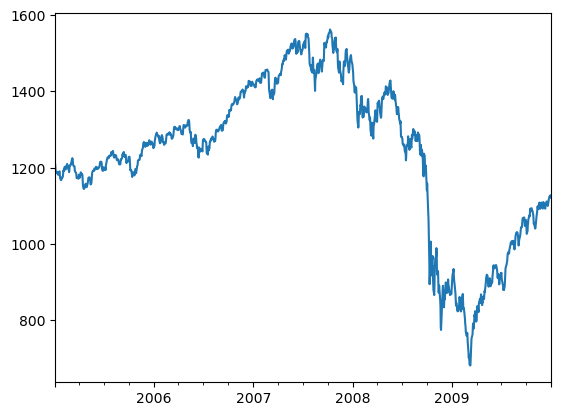

In [91]:
df["y"].plot()

In [39]:
df[df["ds"] > "2008-09-01"]

,ds,y
922,2008-09-02,1277.579956
923,2008-09-03,1274.979980
924,2008-09-04,1236.829956
925,2008-09-05,1242.310059
926,2008-09-08,1267.790039
...,...,...
1254,2009-12-24,1126.479980
1255,2009-12-28,1127.780029
1256,2009-12-29,1126.199951
1257,2009-12-30,1126.420044


<Axes: xlabel='Date'>

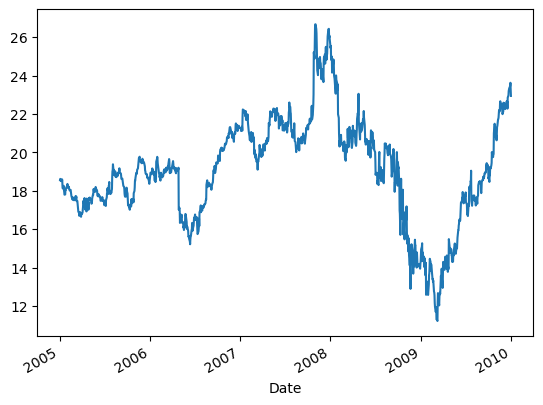

In [44]:
data["Adj Close"]["MSFT"].plot()

/tmp/ipykernel_47390/4007347958.py:193: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


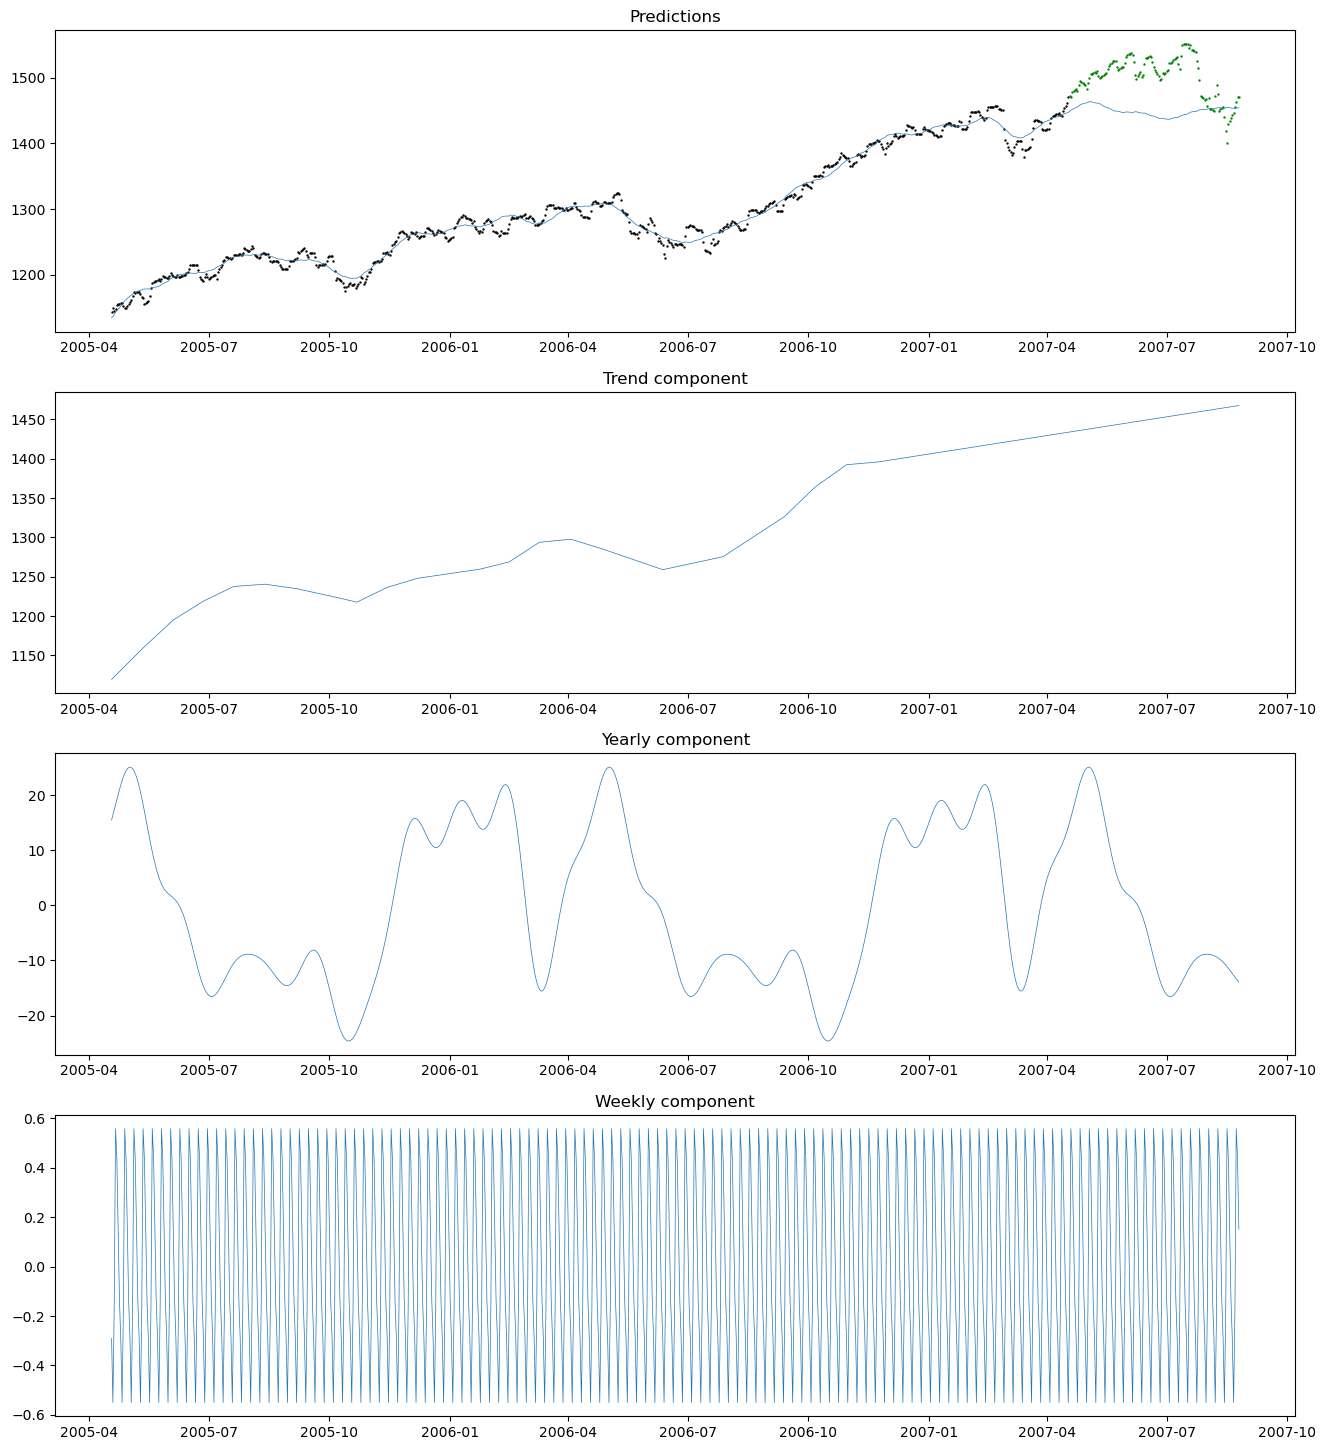

In [136]:
window = 730
horizon = 130
# start = randint(0, len(df) - window - horizon - 1)
start = 105
my_model = MyProphet()
my_model.fit(df[start:start + window])
preds = my_model._predict_map(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

In [144]:
new_model = LinearTrend() + FourierSeasonality(365.25, 10)
new_model.fit(df[start:start + window])

AttributeError: 'AdditiveTimeSeries' object has no attribute 'n_changepoints'

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


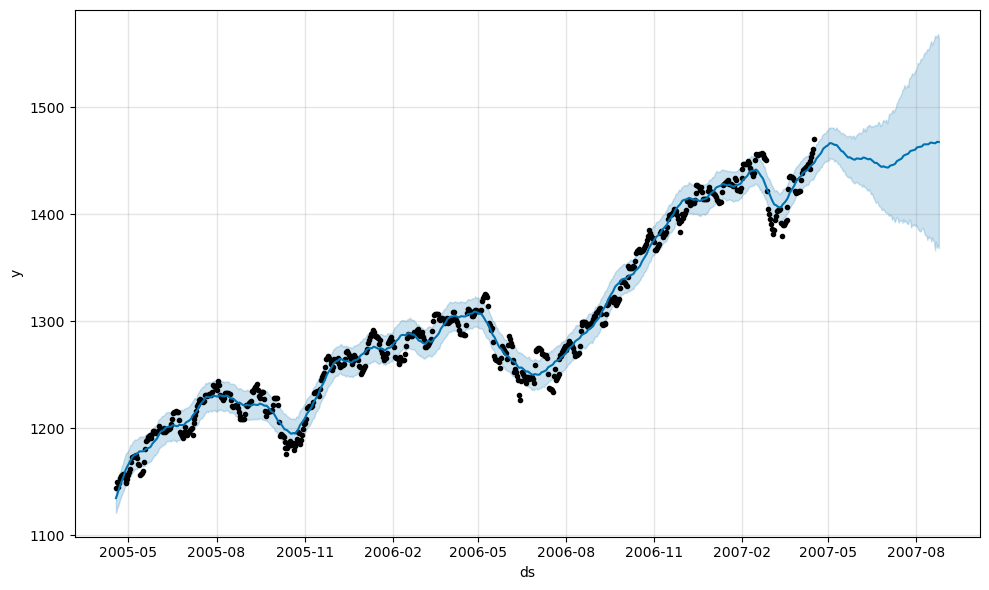

In [137]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df[start:start + window])
future = model.make_future_dataframe(periods=horizon, include_history=True)
forecast = model.predict(future)
fig = model.plot(forecast)

In [138]:
mean_absolute_percentage_error(preds["yhat"], forecast["yhat"])

0.0010129256080573092

In [139]:
mean_absolute_percentage_error(df[start + window:start + window + horizon]["y"], preds["yhat"][window:])

0.03542767845554664

In [140]:
mean_absolute_percentage_error(df[start + window:start + window + horizon]["y"], forecast["yhat"][window:])

0.033402113292251276

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime o

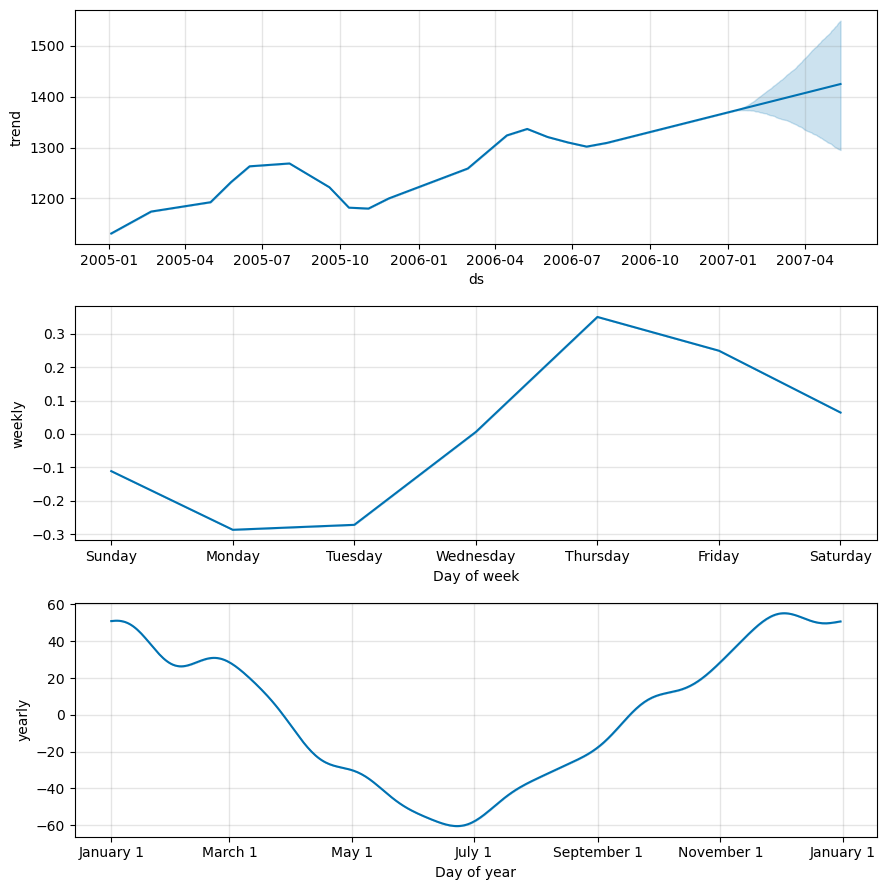

In [130]:
fig = model.plot_components(forecast)

In [104]:
df[start:start + window][["ds", "y"]]

,ds,y
576,2006-08-02,1275.572510
577,2006-08-03,1278.424988
578,2006-08-04,1281.589996
579,2006-08-05,1280.009176
580,2006-08-06,1278.428355
...,...,...
1301,2008-07-27,1249.952494
1302,2008-07-28,1246.647491
1303,2008-07-29,1249.789978
1304,2008-07-30,1274.407501
